# SETUP

In [1]:
%%bash
pip install --upgrade pip tensorflow keras &> pip.log
pip install jupyterlab-vim pydot 'tensorflow' &> /dev/null >> pip.log
apt-get install graphviz -y &> apt.log

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Custom libraries written by myself
from src.drawing import plot_1_data, plot_2_data
from src.prediction_model.lstm import predictLSTM, evaluateLSTM
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import predictLSTM, evaluateLSTM

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

E0000 00:00:1751173616.845009   89451 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751173616.853780   89451 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751173616.879074   89451 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751173616.879109   89451 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751173616.879111   89451 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751173616.879113   89451 computation_placer.cc:177] computation placer already registered. Please check linka

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration

In [3]:
global_conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/model_params.json")
print(global_conf)

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(global_conf.general["model_info_dir"])
cleanDir(global_conf.general["model_checkpoints_dir"])

{
    "general": {
        "model_info_dir": "/le_thanh_van_118/workspace/hiep_workspace/model_info_dir",
        "model_checkpoints_dir": "/le_thanh_van_118/workspace/hiep_workspace/model_checkpoints"
    },
    "prediction": {
        "n_past": 7,
        "n_future": 1,
        "epochs": 20,
        "batch_size": 128
    },
    "reduction": {
        "n_past": 7,
        "n_future": 1,
        "epochs": 20,
        "batch_size": 128,
        "min_number_of_features": 18
    }
}


# MPAIR DATA

## Load dataset

* Every row has a tuple (i, j) which marks a "cell" in the Ho Chi Minh City grid map

| i/j | 0 | 1 | 2 | ... |
|-----|---|---|---|-----|
| 0   |   |   |   |     |
| 1   |   |   |   |     |
| 2   |   |   |   |     |
| ... |   |   |   |     |

* Every cell has its own geographical characteristics
* Every cell represent values of a specific date and specific location

### Raw data

In [4]:
df_mpair_raw = pd.read_csv("MPair.csv")
df_mpair_raw

,i,j,lat,lon,time,PM25_3km,TMP,RH,HPBL,WSPD,...,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD,AIMODEL
0,0,0,11.149747,106.300443,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000
1,0,1,11.149747,106.323330,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000
2,0,2,11.149747,106.346217,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,0.156327,-9999.000000
3,0,3,11.149747,106.369103,2018-01-01,24.740000,25.460614,65.144661,2.448070,2.448070,...,7.265194e+01,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.167487,-9999.000000
4,0,4,11.149747,106.391990,2018-01-01,23.760931,25.462688,65.080498,2.438784,2.438784,...,1.107789e+02,4569.189136,21119.949784,76052.614180,231046.865089,662859.174184,4308.164827,NaN,0.141881,-9999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236845,34,30,10.385233,106.987043,2022-12-31,NaN,25.815809,74.737156,207.873199,3.124345,...,3.072120e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000,14.998473
2236846,34,31,10.385233,107.009930,2022-12-31,NaN,25.815809,75.000397,207.873199,3.215876,...,4.355371e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000,15.201084
2236847,34,32,10.385233,107.032816,2022-12-31,-9999.000000,25.601173,-9999.000000,142.227615,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,0.000000
2236848,34,33,10.385233,107.055703,2022-12-31,-9999.000000,25.560753,-9999.000000,129.865280,-9999.000000,...,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,0.000000


In [5]:
df_mpair_raw.columns

Index(['i', 'j', 'lat', 'lon', 'time', 'PM25_3km', 'TMP', 'RH', 'HPBL', 'WSPD',
       'PRES2M', 'POP', 'ROAD_DEN_1km', 'ROAD_LEN_1km', 'PRIM_ROAD_LEN_1km',
       'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND',
       'TREECOVER', 'WATER', 'NDVI', 'AOD', 'AIMODEL'],
      dtype='object')

### Statistics

In [6]:
df_mpair_stat = df_mpair_raw.describe()

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [7]:
df_mpair_stat.iloc[:, list(range(0,12))]

,i,j,lat,lon,PM25_3km,TMP,RH,HPBL,WSPD,PRES2M,POP,ROAD_DEN_1km
count,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.222980e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06
mean,1.700000e+01,1.700000e+01,1.076749e+01,1.066895e+02,-1.753033e+03,-1.362026e+03,-1.661220e+03,-9.405143e+02,-1.725172e+03,8.546206e+04,-1.543609e+04,-5.388961e+37
std,1.009951e+01,1.009951e+01,2.270946e-01,2.311440e-01,3.818433e+03,3.463384e+03,3.810681e+03,3.635621e+03,3.781445e+03,3.828034e+04,3.946800e+04,1.242320e+38
min,0.000000e+00,0.000000e+00,1.038523e+01,1.063004e+02,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999900e+04,-3.402823e+38
25%,8.000000e+00,8.000000e+00,1.056512e+01,1.064835e+02,7.578345e+00,2.544704e+01,6.850341e+01,3.422755e+02,1.769627e+00,1.004902e+05,1.236246e+02,6.451674e-01
50%,1.700000e+01,1.700000e+01,1.076749e+01,1.066895e+02,1.195651e+01,2.657075e+01,7.868076e+01,4.752339e+02,2.600184e+00,1.007760e+05,5.454543e+02,4.697491e+00
75%,2.600000e+01,2.600000e+01,1.096986e+01,1.068955e+02,1.688797e+01,2.744273e+01,8.641529e+01,6.056798e+02,3.479031e+00,1.009805e+05,1.298022e+03,8.067769e+00
max,3.400000e+01,3.400000e+01,1.114975e+01,1.070786e+02,1.028131e+02,3.323537e+01,9.956794e+01,1.568239e+03,1.281917e+01,1.015956e+05,5.684037e+04,3.491340e+01


In [8]:
df_mpair_stat.iloc[:, list(range(12,24))]

,ROAD_LEN_1km,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD,AIMODEL
count,1.822348e+06,394416.000000,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,2.236850e+06,779702.000000,2.235890e+06,2.236850e+06
mean,1.067029e+04,131.058152,-inf,1.261559e+04,1.638713e+05,1.416377e+05,1.060141e+05,2.498923e+05,7.916829e+04,-2501.601072,-inf,-5.994904e+03
std,9.746935e+03,832.895664,inf,2.472116e+04,2.217233e+05,1.922052e+05,9.731447e+04,2.296573e+05,1.633040e+05,7461.592816,NaN,4.906239e+03
min,0.000000e+00,0.000000,-1.797693e+308,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9999.000000,-inf,-9.999000e+03
25%,4.510964e+03,0.000000,2.799286e+01,5.552163e+02,2.151326e+03,3.157222e+03,1.093264e+04,1.518208e+04,5.424711e+01,-9999.000000,-9.999000e+03,-9.999000e+03
50%,8.658898e+03,0.000000,7.090635e+01,4.823034e+03,7.965172e+04,4.737217e+04,1.005260e+05,2.117074e+05,6.301000e+03,1718.917701,-9.999000e+03,-9.999000e+03
75%,1.443556e+04,0.000000,1.625445e+02,1.730109e+04,2.221508e+05,2.185754e+05,1.665998e+05,3.996788e+05,8.267868e+04,4856.353630,4.555829e-01,1.600679e+01
max,5.460836e+04,8309.180000,6.176464e+03,2.330341e+05,9.817100e+05,8.584316e+05,5.151408e+05,9.725638e+05,1.249447e+06,7861.422519,5.469734e+00,4.573877e+01


In [9]:
df_mpair_raw.isnull().sum()

i                          0
j                          0
lat                        0
lon                        0
time                       0
PM25_3km               13870
TMP                        0
RH                         0
HPBL                       0
WSPD                       0
PRES2M                     0
POP                        0
ROAD_DEN_1km               0
ROAD_LEN_1km          414502
PRIM_ROAD_LEN_1km    1842434
NEAR_DIST                  0
BARELAND                   0
BUILTUP                    0
CROPLAND                   0
GRASSLAND                  0
TREECOVER                  0
WATER                      0
NDVI                 1457148
AOD                      960
AIMODEL                    0
dtype: int64

### Drop columns

In [10]:
df_mpair_raw.drop(["AIMODEL"], axis=1, inplace=True)
df_mpair_raw

,i,j,lat,lon,time,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD
0,0,0,11.149747,106.300443,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
1,0,1,11.149747,106.323330,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
2,0,2,11.149747,106.346217,2018-01-01,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,0.156327
3,0,3,11.149747,106.369103,2018-01-01,24.740000,25.460614,65.144661,2.448070,2.448070,...,NaN,7.265194e+01,14453.144036,30347.516088,54101.838731,203551.710735,683877.574149,13604.234765,NaN,0.167487
4,0,4,11.149747,106.391990,2018-01-01,23.760931,25.462688,65.080498,2.438784,2.438784,...,NaN,1.107789e+02,4569.189136,21119.949784,76052.614180,231046.865089,662859.174184,4308.164827,NaN,0.141881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2236845,34,30,10.385233,106.987043,2022-12-31,NaN,25.815809,74.737156,207.873199,3.124345,...,NaN,3.072120e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000
2236846,34,31,10.385233,107.009930,2022-12-31,NaN,25.815809,75.000397,207.873199,3.215876,...,NaN,4.355371e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN,-9999.000000
2236847,34,32,10.385233,107.032816,2022-12-31,-9999.000000,25.601173,-9999.000000,142.227615,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
2236848,34,33,10.385233,107.055703,2022-12-31,-9999.000000,25.560753,-9999.000000,129.865280,-9999.000000,...,0.0,-1.797693e+308,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000


### Remove invalid data

In [11]:
numerical_columns = df_mpair_raw.columns[5:]
df_mpair_raw = df_mpair_raw[(df_mpair_raw[numerical_columns] > -9999).all(1)]
df_mpair_raw

,i,j,lat,lon,time,PM25_3km,TMP,RH,HPBL,WSPD,...,PRIM_ROAD_LEN_1km,NEAR_DIST,BARELAND,BUILTUP,CROPLAND,GRASSLAND,TREECOVER,WATER,NDVI,AOD
645,18,15,10.745004,106.643743,2018-01-01,30.845961,25.045032,71.926500,2.339113,2.339113,...,3663.8025,6.909909,3286.840750,882259.549565,2312.864958,10563.271194,43083.900165,58415.405794,1742.916058,1.999975
647,18,17,10.745004,106.689516,2018-01-01,30.939211,25.082829,71.464797,2.237909,2.237909,...,4633.5020,18.555218,6924.069379,742455.993765,8958.648184,37665.567156,123921.617453,79841.648016,2087.080168,1.248172
680,19,15,10.722519,106.643743,2018-01-01,27.156076,25.022745,72.305654,2.302683,2.302683,...,2284.2550,70.356268,7978.455406,427846.224207,63148.502720,114955.708607,269190.714441,115011.679587,3690.303474,1.971691
1802,16,17,10.789976,106.689516,2018-01-02,52.154430,24.712185,73.392725,1.881799,1.881799,...,4548.5900,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.914681
1837,17,17,10.767490,106.689516,2018-01-02,49.599480,24.698446,73.641532,1.879498,1.879498,...,8309.1800,17.300117,1895.437302,879546.385595,229.889184,2906.313289,68310.042059,46929.703983,1876.516122,1.189908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233787,17,17,10.767490,106.689516,2022-12-29,27.491894,25.897594,67.093735,827.818787,2.823764,...,8309.1800,17.300117,1895.437302,879546.385595,229.889184,2906.313289,68310.042059,46929.703983,1876.516122,0.239528
2233788,17,18,10.767490,106.712403,2022-12-29,23.209021,27.186907,59.783350,880.392334,2.464040,...,4869.2314,28.249591,25943.414161,502457.783018,27350.370312,69966.235794,203949.897411,170512.111735,2389.140541,0.168873
2233820,18,15,10.745004,106.643743,2022-12-29,29.272182,26.616703,59.667720,621.919495,2.330549,...,3663.8025,6.909909,3286.840750,882259.549565,2312.864958,10563.271194,43083.900165,58415.405794,1742.916058,0.186290
2233822,18,17,10.745004,106.689516,2022-12-29,28.683048,25.632614,68.206148,565.613037,2.169897,...,4633.5020,18.555218,6924.069379,742455.993765,8958.648184,37665.567156,123921.617453,79841.648016,2087.080168,0.199954


### Data preparation

* Convert "time" columns to Pandas datetime
* Set "time" column as index
* Sort data by "time"
* Lowercase all column names

In [12]:
# Convert "time" columns to Pandas datetime
df_mpair_raw = df_mpair_raw.assign(time=pd.to_datetime(df_mpair_raw["time"]))

# Set "time" column as index
df_mpair_raw.set_index("time", inplace=True)

# Lower case all column names
df_mpair_raw = df_mpair_raw.rename(columns={name: name.lower() for name in df_mpair_raw.columns})

# Print
df_mpair_raw

,i,j,lat,lon,pm25_3km,tmp,rh,hpbl,wspd,pres2m,...,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01,18,15,10.745004,106.643743,30.845961,25.045032,71.926500,2.339113,2.339113,100930.458102,...,3663.8025,6.909909,3286.840750,882259.549565,2312.864958,10563.271194,43083.900165,58415.405794,1742.916058,1.999975
2018-01-01,18,17,10.745004,106.689516,30.939211,25.082829,71.464797,2.237909,2.237909,100915.732074,...,4633.5020,18.555218,6924.069379,742455.993765,8958.648184,37665.567156,123921.617453,79841.648016,2087.080168,1.248172
2018-01-01,19,15,10.722519,106.643743,27.156076,25.022745,72.305654,2.302683,2.302683,100933.214552,...,2284.2550,70.356268,7978.455406,427846.224207,63148.502720,114955.708607,269190.714441,115011.679587,3690.303474,1.971691
2018-01-02,16,17,10.789976,106.689516,52.154430,24.712185,73.392725,1.881799,1.881799,100874.453618,...,4548.5900,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.914681
2018-01-02,17,17,10.767490,106.689516,49.599480,24.698446,73.641532,1.879498,1.879498,100880.492220,...,8309.1800,17.300117,1895.437302,879546.385595,229.889184,2906.313289,68310.042059,46929.703983,1876.516122,1.189908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29,17,17,10.767490,106.689516,27.491894,25.897594,67.093735,827.818787,2.823764,101331.265625,...,8309.1800,17.300117,1895.437302,879546.385595,229.889184,2906.313289,68310.042059,46929.703983,1876.516122,0.239528
2022-12-29,17,18,10.767490,106.712403,23.209021,27.186907,59.783350,880.392334,2.464040,101357.992188,...,4869.2314,28.249591,25943.414161,502457.783018,27350.370312,69966.235794,203949.897411,170512.111735,2389.140541,0.168873
2022-12-29,18,15,10.745004,106.643743,29.272182,26.616703,59.667720,621.919495,2.330549,101354.976562,...,3663.8025,6.909909,3286.840750,882259.549565,2312.864958,10563.271194,43083.900165,58415.405794,1742.916058,0.186290


## Preprocessing

In [13]:
df_mpair = copy.deepcopy(df_mpair_raw)

### Extract columns: time, i, j

In [14]:
mpair_i_column = df_mpair.loc[:,"i"]
mpair_j_column = df_mpair.loc[:, "j"]
print(mpair_i_column)
print(mpair_j_column)

time
2018-01-01    18
2018-01-01    18
2018-01-01    19
2018-01-02    16
2018-01-02    17
              ..
2022-12-29    17
2022-12-29    17
2022-12-29    18
2022-12-29    18
2022-12-29    19
Name: i, Length: 3759, dtype: int64
time
2018-01-01    15
2018-01-01    17
2018-01-01    15
2018-01-02    17
2018-01-02    17
              ..
2022-12-29    17
2022-12-29    18
2022-12-29    15
2022-12-29    17
2022-12-29    15
Name: j, Length: 3759, dtype: int64


In [15]:
# Get the time indices
mpair_time_indices = df_mpair.index
mpair_time_indices

DatetimeIndex(['2018-01-01', '2018-01-01', '2018-01-01', '2018-01-02',
               '2018-01-02', '2018-01-02', '2018-01-02', '2018-01-02',
               '2018-01-03', '2018-01-03',
               ...
               '2022-12-26', '2022-12-26', '2022-12-28', '2022-12-28',
               '2022-12-29', '2022-12-29', '2022-12-29', '2022-12-29',
               '2022-12-29', '2022-12-29'],
              dtype='datetime64[ns]', name='time', length=3759, freq=None)

### Split into features and labels
* Label: pm25_3km
* Features: other columns
    * Dynamic features
    * Static features

In [16]:
mpair_label = "pm25_3km"
mpair_features = [item for item in df_mpair.columns if item not in [mpair_label, "i", "j"]]
mpair_features

['lat',
 'lon',
 'tmp',
 'rh',
 'hpbl',
 'wspd',
 'pres2m',
 'pop',
 'road_den_1km',
 'road_len_1km',
 'prim_road_len_1km',
 'near_dist',
 'bareland',
 'builtup',
 'cropland',
 'grassland',
 'treecover',
 'water',
 'ndvi',
 'aod']

### Define static features and dynamic features

In [17]:
mpair_dyn_feats = ["tmp", "rh", "hpbl", "wspd", "aod", "wspd"]
mpair_stat_feats = list(set(mpair_features) - set(mpair_dyn_feats))
print(mpair_dyn_feats)
print(mpair_stat_feats)

['tmp', 'rh', 'hpbl', 'wspd', 'aod', 'wspd']
['grassland', 'prim_road_len_1km', 'road_den_1km', 'bareland', 'cropland', 'road_len_1km', 'lon', 'pop', 'near_dist', 'lat', 'pres2m', 'builtup', 'ndvi', 'treecover', 'water']


In [18]:
X_mpair = df_mpair.loc[:, mpair_features]
y_mpair = df_mpair.loc[:, mpair_label].to_frame()

In [19]:
X_mpair

,lat,lon,tmp,rh,hpbl,wspd,pres2m,pop,road_den_1km,road_len_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
time,,,,,,,,,,,,,,,,,,,,
2018-01-01,10.745004,106.643743,25.045032,71.926500,2.339113,2.339113,100930.458102,56820.605,32.349976,49847.800,3663.8025,6.909909,3286.840750,882259.549565,2312.864958,10563.271194,43083.900165,58415.405794,1742.916058,1.999975
2018-01-01,10.745004,106.689516,25.082829,71.464797,2.237909,2.237909,100915.732074,47386.200,26.514095,42310.880,4633.5020,18.555218,6924.069379,742455.993765,8958.648184,37665.567156,123921.617453,79841.648016,2087.080168,1.248172
2018-01-01,10.722519,106.643743,25.022745,72.305654,2.302683,2.302683,100933.214552,9929.431,17.303484,28121.441,2284.2550,70.356268,7978.455406,427846.224207,63148.502720,114955.708607,269190.714441,115011.679587,3690.303474,1.971691
2018-01-02,10.789976,106.689516,24.712185,73.392725,1.881799,1.881799,100874.453618,47421.883,30.315554,47754.887,4548.5900,19.481558,1056.256477,878404.088663,9.037443,1221.246398,86858.898791,32195.290892,1830.941629,0.914681
2018-01-02,10.767490,106.689516,24.698446,73.641532,1.879498,1.879498,100880.492220,44587.590,34.893220,54608.355,8309.1800,17.300117,1895.437302,879546.385595,229.889184,2906.313289,68310.042059,46929.703983,1876.516122,1.189908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29,10.767490,106.689516,25.897594,67.093735,827.818787,2.823764,101331.265625,44587.590,34.893220,54608.355,8309.1800,17.300117,1895.437302,879546.385595,229.889184,2906.313289,68310.042059,46929.703983,1876.516122,0.239528
2022-12-29,10.767490,106.712403,27.186907,59.783350,880.392334,2.464040,101357.992188,6337.609,20.310135,34510.500,4869.2314,28.249591,25943.414161,502457.783018,27350.370312,69966.235794,203949.897411,170512.111735,2389.140541,0.168873
2022-12-29,10.745004,106.643743,26.616703,59.667720,621.919495,2.330549,101354.976562,56820.605,32.349976,49847.800,3663.8025,6.909909,3286.840750,882259.549565,2312.864958,10563.271194,43083.900165,58415.405794,1742.916058,0.186290


In [20]:
y_mpair

,pm25_3km
time,
2018-01-01,30.845961
2018-01-01,30.939211
2018-01-01,27.156076
2018-01-02,52.154430
2018-01-02,49.599480
...,...
2022-12-29,27.491894
2022-12-29,23.209021
2022-12-29,29.272182


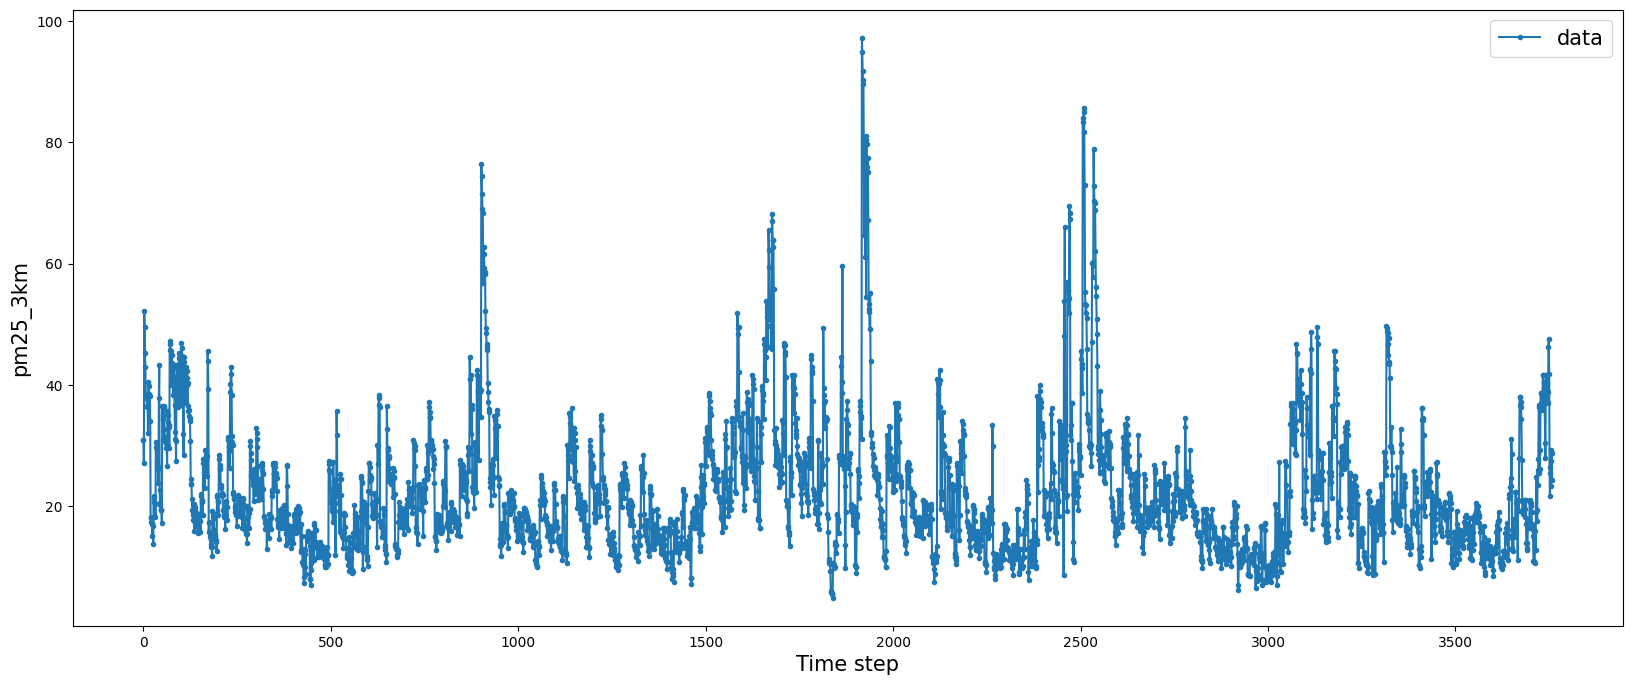

In [21]:
plot_1_data(data=y_mpair, datalabel="data", xlabel="Time step", ylabel="pm25_3km")

### Data normalization

In [22]:
mpair_features_scaler = MinMaxScaler()
X_mpair_scaled = mpair_features_scaler.fit_transform(X_mpair)
X_mpair_scaled = pd.DataFrame(X_mpair_scaled, columns=X_mpair.columns)
X_mpair_scaled

,lat,lon,tmp,rh,hpbl,wspd,pres2m,pop,road_den_1km,road_len_1km,prim_road_len_1km,near_dist,bareland,builtup,cropland,grassland,treecover,water,ndvi,aod
0,0.333333,0.000000,0.362488,0.485014,0.000915,0.239829,0.480631,1.000000,0.855413,0.820268,0.228973,0.000000,0.089628,1.000000,0.036488,0.082139,0.000000,0.189566,0.000000,0.398431
1,0.333333,0.666667,0.365850,0.474331,0.000827,0.220990,0.468043,0.813117,0.523636,0.535715,0.389921,0.183546,0.235777,0.692343,0.141744,0.320433,0.357520,0.344473,0.176731,0.247678
2,0.000000,0.000000,0.360506,0.493787,0.000884,0.233048,0.482987,0.071149,0.000000,0.000000,0.000000,1.000000,0.278143,0.000000,1.000000,1.000000,1.000000,0.598744,1.000000,0.392759
3,1.000000,0.666667,0.332880,0.518940,0.000516,0.154700,0.432759,0.813824,0.739754,0.741251,0.375828,0.198146,0.000000,0.991516,0.000000,0.000000,0.193603,0.000000,0.045202,0.180806
4,0.666667,0.666667,0.331658,0.524697,0.000514,0.154271,0.437921,0.757680,1.000000,1.000000,1.000000,0.163764,0.033719,0.994029,0.003498,0.014816,0.111567,0.106527,0.068605,0.235995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754,0.666667,0.666667,0.438327,0.373191,0.721286,0.330048,0.823238,0.757680,1.000000,1.000000,1.000000,0.163764,0.033719,0.994029,0.003498,0.014816,0.111567,0.106527,0.068605,0.045424
3755,0.666667,1.000000,0.553016,0.204041,0.767165,0.263085,0.846084,0.000000,0.170932,0.241216,0.429047,0.336342,1.000000,0.164193,0.433031,0.604434,0.711460,1.000000,0.331842,0.031256
3756,0.333333,0.000000,0.502294,0.201366,0.541604,0.238235,0.843506,1.000000,0.855413,0.820268,0.228973,0.000000,0.089628,1.000000,0.036488,0.082139,0.000000,0.189566,0.000000,0.034748
3757,0.333333,0.666667,0.414756,0.398931,0.492467,0.208330,0.842371,0.813117,0.523636,0.535715,0.389921,0.183546,0.235777,0.692343,0.141744,0.320433,0.357520,0.344473,0.176731,0.037488


In [23]:
mpair_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_mpair_scaled = mpair_label_scaler.fit_transform(y_mpair)
y_mpair_scaled = pd.DataFrame(y_mpair_scaled, columns=y_mpair.columns)
y_mpair_scaled

,pm25_3km
0,0.281249
1,0.282258
2,0.241324
3,0.511810
4,0.484165
...,...
3754,0.244958
3755,0.198617
3756,0.264221
3757,0.257846


## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25_3km as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [24]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': []}

### Range of dimension

In [25]:
RANGE_OF_DIMENSION = range(global_conf.reduction["min_number_of_features"], X_mpair_scaled.shape[1])
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

18 19 

In [26]:
stophere

NameError: name 'stophere' is not defined

### Prediction + LSTM-Seq2Seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
  # Apply Seq2seq
  lstms2s = LSTMSeq2SeqReduction(X_mpair_scaled,
                                 test_percentage=0.2,
                                 latent_dim=n,
                                 epochs=SEQ2SEQ_EPOCHS, batch_size=SEQ2SEQ_BATCH_SIZE,
                                 verbose=0,
                                 n_past=SEQ2SEQ_N_PAST,
                                 n_future=SEQ2SEQ_N_FUTURE,
                                 model_name=f"mpair_lstms2s_dim_reduction_{n}_features")
  X_mpair_scaled_lstm_s2s_encoded = lstms2s.execute()

  lstms2s.get_model_info()
  lstms2s.get_encoder_model_info()

  # Prediction
  y_pred, y_test = predictLSTM(X_mpair_scaled_lstm_s2s_encoded, y_mpair_scaled,
                             MPAIR_LSTM_N_PAST, MPAIR_LSTM_N_FUTURE, MPAIR_LSTM_EPOCHS, MPAIR_LSTM_BATCH_SIZE,
                             model_name=f"mpair_lstm_prediction_with_lstms2s_dim_reduction_{n}_features",
                             verbose=0)

  # Evaluation
  all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)

  # Logging
  loopresults[n]["mae"] = avg_mae
  loopresults[n]["encoded_data"] = X_mpair_scaled_lstm_s2s_encoded
  loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
  if loopresults[n]["mae"] < best_mae:
    best_num_of_components = n
    best_mae = loopresults[n]["mae"]
    best_encoded_data = loopresults[n]["encoded_data"]
    best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(MPAIR_LSTM_N_FUTURE):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

### Prediction + GRU-Seq2Seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
  # Apply Seq2seq
  grus2s = GRUSeq2SeqReduction(X_mpair_scaled, test_percentage=0.2, latent_dim=n, epochs=SEQ2SEQ_EPOCHS, batch_size=SEQ2SEQ_BATCH_SIZE,
                               n_past=SEQ2SEQ_N_PAST,
                               n_future=SEQ2SEQ_N_FUTURE,
                               verbose=0)
  X_mpair_scaled_gru_s2s_encoded = grus2s.execute()

  grus2s.get_model_info()
  grus2s.get_encoder_model_info()

  # Prediction
  y_pred, y_test = predictLSTM(X_mpair_scaled_gru_s2s_encoded, y_mpair_scaled,
                             MPAIR_LSTM_N_PAST, MPAIR_LSTM_N_FUTURE, MPAIR_LSTM_EPOCHS, MPAIR_LSTM_BATCH_SIZE,
                             model_name=f"mpair_lstm_grus2s_dim_reduction_{n}_features",
                             verbose=0)

  # Evaluation
  all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)

  # Logging
  print(f"N = {n} - MAE = {avg_mae}")
  loopresults[n]["mae"] = avg_mae
  loopresults[n]["encoded_data"] = X_mpair_scaled_gru_s2s_encoded
  loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.1))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
  if loopresults[n]["mae"] < best_mae:
    best_num_of_components = n
    best_mae = loopresults[n]["mae"]
    best_encoded_data = loopresults[n]["encoded_data"]
    best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(MPAIR_LSTM_N_FUTURE):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board

#### Prepare reduced data

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [ ]:
loopresults = {i:{"mae": None, "encoded_data": None, "evaluation_data": None} for i in RANGE_OF_DIMENSION}

# Loop between min and (number of features - 1) to choose what number is the best
for n in RANGE_OF_DIMENSION:
  # Apply Seq2seq
  cnnlstms2s = CNNLSTMSeq2SeqReduction(X_mpair_scaled, test_percentage=0.2, latent_dim=n, epochs=SEQ2SEQ_EPOCHS, batch_size=SEQ2SEQ_BATCH_SIZE, verbose=0)
  X_mpair_scaled_cnnlstm_s2s_encoded = cnnlstms2s.execute()

  cnnlstms2s.get_model_info()
  cnnlstms2s.get_encoder_model_info()

  # Prediction
  y_pred, y_test = predictLSTM(X_mpair_scaled_cnnlstm_s2s_encoded, y_mpair_scaled,
                             MPAIR_LSTM_N_PAST, MPAIR_LSTM_N_FUTURE, MPAIR_LSTM_EPOCHS, MPAIR_LSTM_BATCH_SIZE,
                             model_name=f"mpair_lstm_cnnlstm_s2s_dim_reduction_{n}_features",
                             verbose=0)

  # Evaluation
  all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae = evaluateLSTM(y_pred, y_test, mpair_label_scaler, verbose=0)

  # Logging
  loopresults[n]["mae"] = avg_mae
  loopresults[n]["encoded_data"] = X_mpair_scaled_cnnlstm_s2s_encoded
  loopresults[n]["evaluation_data"] = (all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae)

In [ ]:
for n in loopresults.keys():
  print(f"N = {n} - MAE = {loopresults[n]['mae']}")

values = [loopresults[n]["mae"] for n in RANGE_OF_DIMENSION]
plt.plot(RANGE_OF_DIMENSION, values)
plt.xticks(RANGE_OF_DIMENSION)
plt.xlabel("Number of components")
plt.yticks(np.arange(min(values), max(values) + 0.1, 0.2))
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

best_mae = 1000
best_num_of_components = 0
best_encoded_data = None
best_evaluation_data = None
for n in loopresults.keys():
  if loopresults[n]["mae"] < best_mae:
    best_num_of_components = n
    best_mae = loopresults[n]["mae"]
    best_encoded_data = loopresults[n]["encoded_data"]
    best_evaluation_data = loopresults[n]["evaluation_data"]

evaluation_board['dim_reduction_method'] += ["CNN-LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]

In [ ]:
all_days_inv_y_pred, all_days_inv_y_test, _, _ = best_evaluation_data
for day in range(MPAIR_LSTM_N_FUTURE):
  inv_y_pred = all_days_inv_y_pred[day,:,:]
  inv_y_test = all_days_inv_y_test[day,:,:]
  print(f"inv_y_pred.shape = {inv_y_pred.shape}\ninv_y_test.shape = {inv_y_test.shape}")
  plot_2_data(data1=inv_y_pred,
              data2=inv_y_test,
              datalabel1="Prediction",
              datalabel2="Actual",
              xlabel="Time step",
              ylabel="PM2.5")

In [ ]:
df_evaluation_board = pd.DataFrame(evaluation_board)
df_evaluation_board